In [203]:
import math
from random import *

import cv2
import matplotlib.pyplot as plt
import numpy
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

_X = []
_y = []
_roi_start = int(30 / 0.6)
_roi_end = int(150 / 0.6)
_scale_div = 10


def format_line(line):
    line = line.replace("[", "")
    line = line.replace("]", "")
    list = line.split(",")
    d_list = []
    for l in list:
        d_list.append(int(l))
    return d_list


def open_log(file_name):
    global _X, _y
    file = open(file_name)
    if file:
        lines = file.readlines()
        x = []
        y = []
        for line in lines:
            data = format_line(line)
            x.append(data[1:])
            y.append(data[0])
        file.close()
        _X = np.array(x)
        _y = np.array(y)
        print(_X.shape)
        print(_y.shape)


def flip_lr(x, y):
    x1 = np.flip(x[:, :300], axis=1)
    x2 = np.flip(x[:, 300:], axis=1)
    y1 = -y
    return np.concatenate((x1, x2), axis=1), y1


open_log("train_01.log")

(3085, 600)
(3085,)


## convert -60 ~ 60 angle to 3 class left, center, right

In [204]:
_div = 45
X = _X
# y = _y / 30
y = _y / _div
y = np.round(y)
_cat = int(max(y)) - int(min(y)) + 1
print(f"{min(y)} ~ {max(y)} => {_cat} categories")

-1.0 ~ 1.0 => 3 categories


## flip left, right for data augmentation

In [205]:
aug_x, aug_y = flip_h(X, y)

In [206]:
X = np.concatenate((X, aug_x))
y = np.concatenate((y, aug_y))
print(X.shape, y.shape)

(6170, 600) (6170,)


## show images

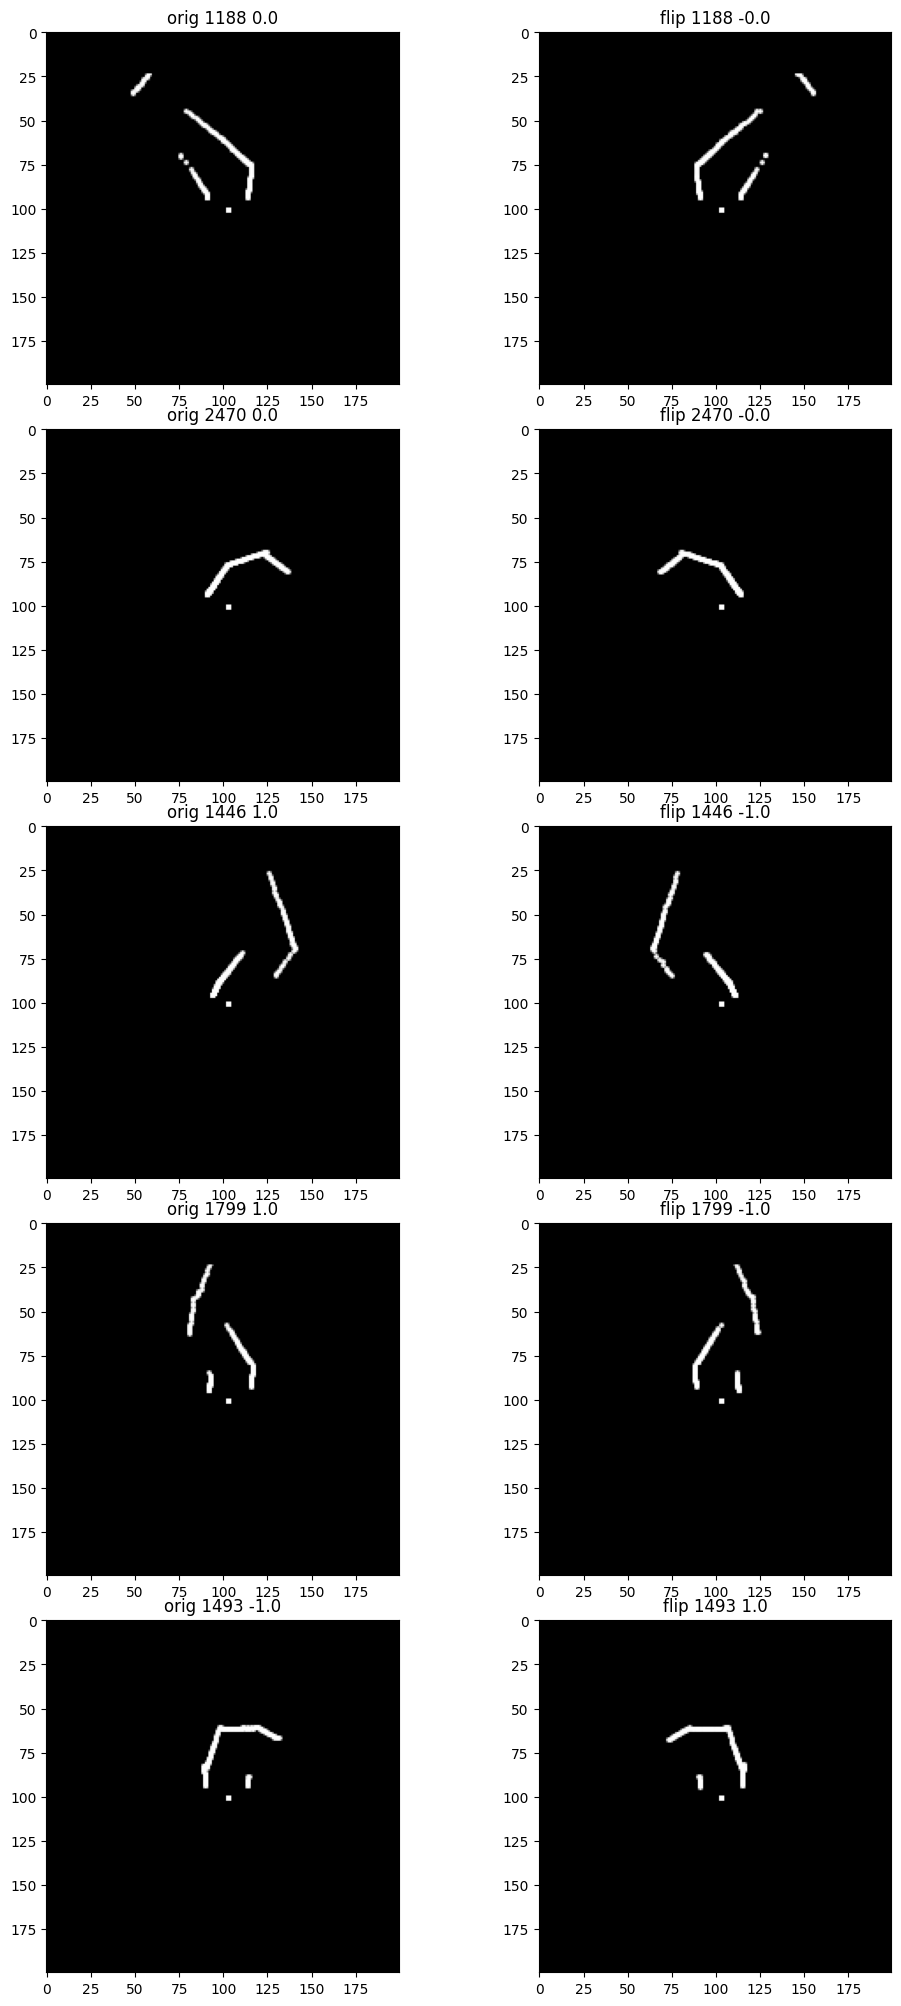

In [264]:
_scale_div = 5


def get_lidar_image(frame):
    fig = plt.figure(figsize=(2, 2), facecolor='black')
    plt.clf()
    plt.autoscale(False)
    # plt.plot(0, 0, "ro", markersize=5)
    # plt.axvline(0, color="g", ls="--")
    # plt.axhline(0, color="g", ls="--")
    # lim = 4000 / _scale_div
    lim = 200
    plt.xlim([-lim, lim])
    plt.ylim([-lim, lim])
    plt.axis('off')

    angle_res = 0.6
    end = int(360 / angle_res)

    # draw lidar image
    xlist = []
    ylist = []
    for i in range(0, end, 1):
        theta = 180 - (angle_res * i)  # lidar installed with -90 degree and rotate CW
        dist = frame[i] / _scale_div  # but screen coordinates CCW so 180 -
        x = dist * math.cos(math.radians(theta))
        y = dist * math.sin(math.radians(theta))  # screen y is reversed
        xlist.append(x)
        ylist.append(y)
    # plt.plot(xlist, ylist, "o", markersize=1, color="black")
    plt.plot(xlist[_roi_start:_roi_end], ylist[_roi_start:_roi_end], "o", markersize=1, color="white")

    fig.canvas.draw()
    img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.close(fig)
    # plt.imshow(img)
    # print(f"{angle:3d}")
    return img


fig, axes = plt.subplots(5, 2, figsize=(10, 20))
fig.tight_layout()
for x in range(5):
    i = randint(0, len(aug_x))
    axes[x][0].imshow(get_lidar_image(X[i]))
    # axes[x][0].set_axis_off()
    axes[x][0].set_title(f"orig {i} {y[i]}")
    axes[x][1].imshow(get_lidar_image(aug_x[i]))
    # axes[x][1].set_axis_off()
    axes[x][1].set_title(f"flip {i} {aug_y[i]}")

new steering angle: 83
new steering angle: 76
new steering angle: 104
new steering angle: 99
new steering angle: 109


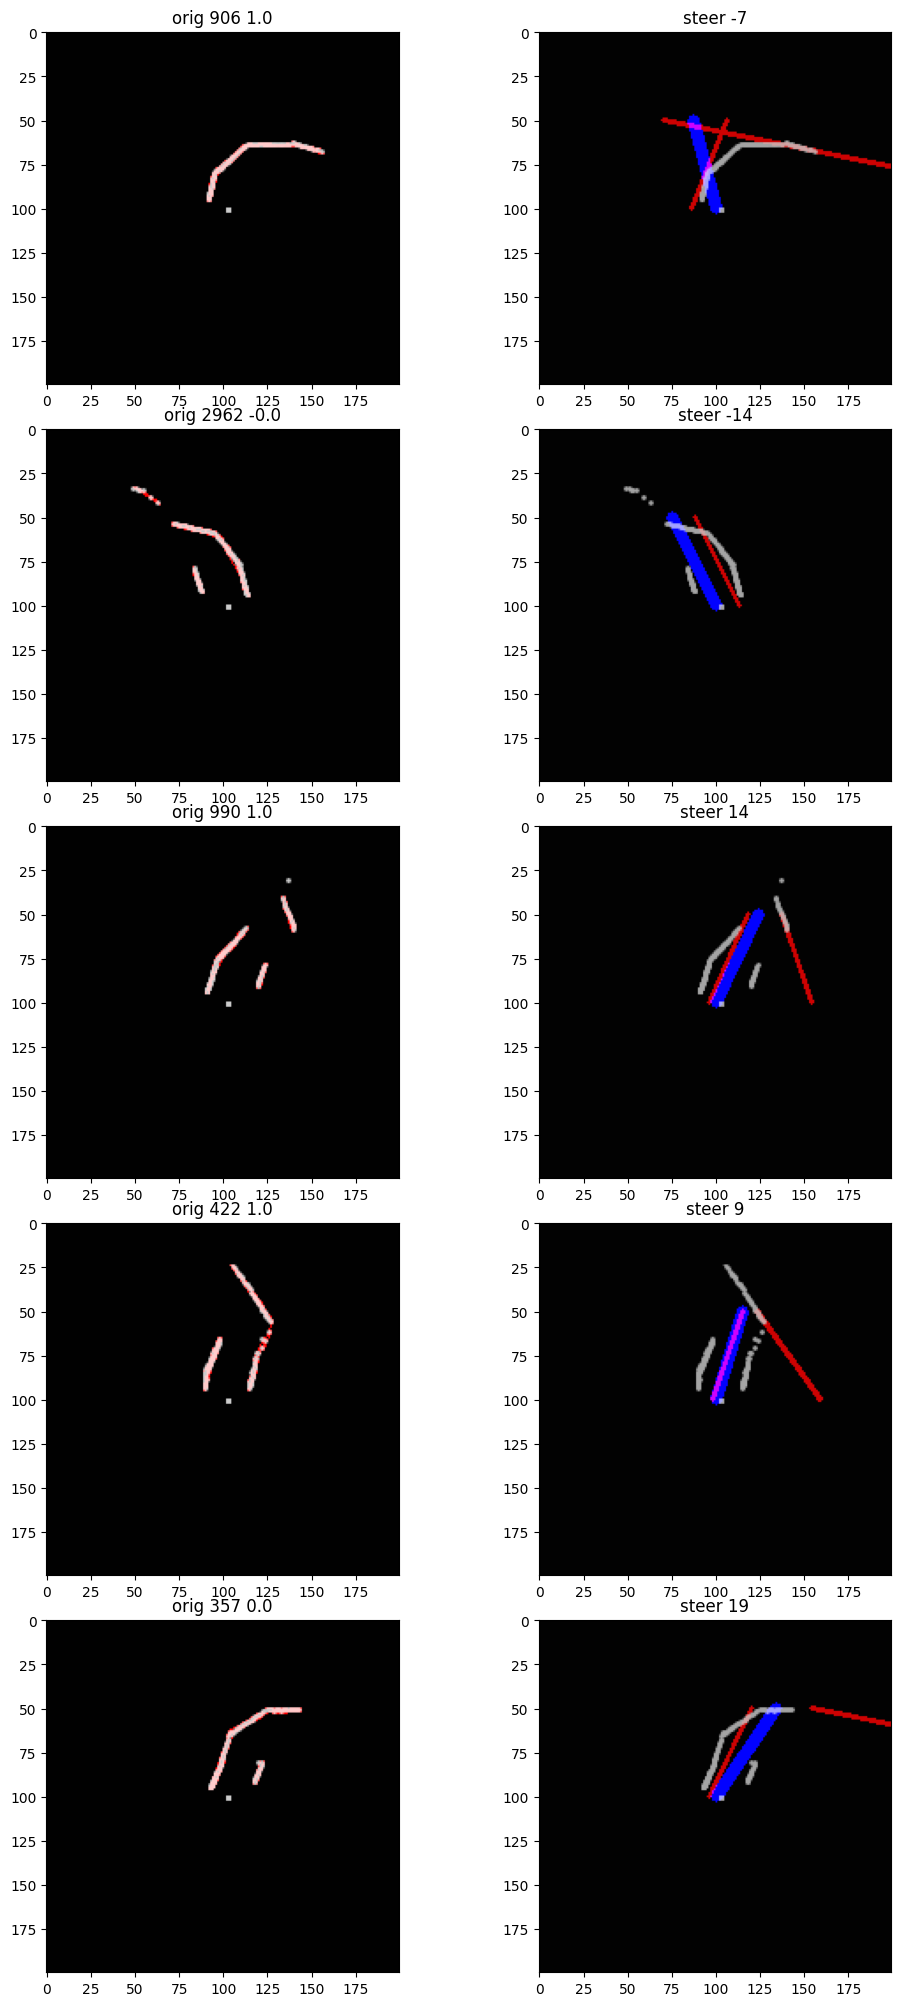

In [269]:
import logging


def length_of_line_segment(line):
    x1, y1, x2, y2 = line
    return math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)


def detect_line_segments(cropped_edges):
    # tuning min_threshold, minLineLength, maxLineGap is a trial and error process by hand
    rho = 1  # precision in pixel, i.e. 1 pixel
    angle = np.pi / 180  # degree in radian, i.e. 1 degree
    min_threshold = 10  # minimal of votes
    line_segments = cv2.HoughLinesP(
        cropped_edges, rho, angle, min_threshold, np.array([]), minLineLength=8, maxLineGap=4
    )

    if line_segments is not None:
        for line_segment in line_segments:
            logging.debug('detected line_segment:')
            logging.debug("%s of length %s" % (line_segment, length_of_line_segment(line_segment[0])))

    return line_segments


def display_lines(frame, lines, line_color=(0, 255, 0), line_width=10):
    line_image = np.zeros_like(frame)
    if lines is not None:
        for line in lines:
            for x1, y1, x2, y2 in line:
                cv2.line(line_image, (x1, y1), (x2, y2), line_color, line_width)
    line_image = cv2.addWeighted(frame, 0.8, line_image, 1, 1)
    return line_image


def make_points(frame, line):
    height, width, _ = frame.shape
    slope, intercept = line
    y1 = height // 2  # center of the frame
    y2 = y1 - (height // 4)  # int(y1 * 1 / 2)  # make points from middle of the frame down

    # bound the coordinates within the frame
    x1 = max(-width, min(2 * width, int((y1 - intercept) / slope)))
    x2 = max(-width, min(2 * width, int((y2 - intercept) / slope)))
    return [[x1, y1, x2, y2]]


def average_slope_intercept(frame, line_segments):
    """
    This function combines line segments into one or two lane lines
    If all line slopes are < 0: then we only have detected left lane
    If all line slopes are > 0: then we only have detected right lane
    """
    lane_lines = []
    if line_segments is None:
        logging.info('No line_segment segments detected')
        return lane_lines

    height, width, _ = frame.shape
    left_fit = []
    right_fit = []

    boundary = 1 / 3
    left_region_boundary = width * (
        1 - boundary
    )  # left lane line segment should be on left 2/3 of the screen
    right_region_boundary = width * boundary  # right lane line segment should be on left 2/3 of the screen

    for line_segment in line_segments:
        for x1, y1, x2, y2 in line_segment:
            if x1 == x2:
                logging.info('skipping vertical line segment (slope=inf): %s' % line_segment)
                continue
            fit = np.polyfit((x1, x2), (y1, y2), 1)
            slope = fit[0]
            intercept = fit[1]
            if slope < 0:
                if x1 < left_region_boundary and x2 < left_region_boundary:
                    left_fit.append((slope, intercept))
            else:
                if x1 > right_region_boundary and x2 > right_region_boundary:
                    right_fit.append((slope, intercept))

    left_fit_average = np.average(left_fit, axis=0)
    if len(left_fit) > 0:
        lane_lines.append(make_points(frame, left_fit_average))

    right_fit_average = np.average(right_fit, axis=0)
    if len(right_fit) > 0:
        lane_lines.append(make_points(frame, right_fit_average))

    logging.debug('lane lines: %s' % lane_lines)  # [[[316, 720, 484, 432]], [[1009, 720, 718, 432]]]

    return lane_lines


def compute_steering_angle(frame, lane_lines):
    """Find the steering angle based on lane line coordinate
    We assume that camera is calibrated to point to dead center
    """
    if len(lane_lines) == 0:
        logging.info('No lane lines detected, do nothing')
        return -90

    height, width, _ = frame.shape
    if len(lane_lines) == 1:
        logging.debug('Only detected one lane line, just follow it. %s' % lane_lines[0])
        x1, _, x2, _ = lane_lines[0][0]
        x_offset = x2 - x1
    else:
        _, _, left_x2, _ = lane_lines[0][0]
        _, _, right_x2, _ = lane_lines[1][0]
        camera_mid_offset_percent = 0.02  # 0.0 means car pointing to center, -0.03: car is centered to left, +0.03 means car pointing to right
        mid = int(width / 2 * (1 + camera_mid_offset_percent))
        x_offset = (left_x2 + right_x2) / 2 - mid

    # find the steering angle, which is angle between navigation direction to end of center line
    y_offset = int(height / 2)

    angle_to_mid_radian = math.atan(x_offset / y_offset)  # angle (in radian) to center vertical line
    angle_to_mid_deg = int(
        angle_to_mid_radian * 180.0 / math.pi
    )  # angle (in degrees) to center vertical line
    steering_angle = angle_to_mid_deg + 90  # this is the steering angle needed by picar front wheel

    print('new steering angle: %s' % steering_angle)
    return steering_angle


def display_heading_line(
    frame,
    steering_angle,
    line_color=(0, 0, 255),
    line_width=5,
):
    heading_image = np.zeros_like(frame)
    height, width, _ = frame.shape

    # figure out the heading line from steering angle
    # heading line (x1,y1) is always center bottom of the screen
    # (x2, y2) requires a bit of trigonometry

    # Note: the steering angle of:
    # 0-89 degree: turn left
    # 90 degree: going straight
    # 91-180 degree: turn right
    steering_angle_radian = steering_angle / 180.0 * math.pi
    x1 = int(width / 2)
    y1 = int(height / 2)
    x2 = int(x1 - height / 2 / math.tan(steering_angle_radian))
    # y2 = int(height / 2)
    y2 = y1 - (height // 4)

    cv2.line(heading_image, (x1, y1), (x2, y2), line_color, line_width)
    heading_image = cv2.addWeighted(frame, 0.8, heading_image, 1, 1)

    return heading_image


cnt = 5
logging.basicConfig(level=logging.INFO)
fig, axes = plt.subplots(cnt, 2, figsize=(10, 20))
fig.tight_layout()
for x in range(cnt):
    i = randint(0, len(aug_x))

    img = get_lidar_image(X[i])
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    line_segments = detect_line_segments(img_gray)
    line_segment_image = display_lines(img, line_segments, line_color=(255, 0, 0), line_width=1)
    lane_lines = average_slope_intercept(img, line_segments)
    lane_lines_image = display_lines(img, lane_lines, line_color=(255, 0, 0), line_width=2)

    new_steering_angle = compute_steering_angle(lane_lines_image, lane_lines)
    curr_heading_image = display_heading_line(lane_lines_image, new_steering_angle)

    axes[x][0].imshow(line_segment_image)
    axes[x][0].set_title(f"orig {i} {y[i]}")

    axes[x][1].imshow(curr_heading_image)
    axes[x][1].set_title(f"steer {new_steering_angle - 90}")

(array([1788., 2594., 1788.]),
 array([-1.        , -0.33333333,  0.33333333,  1.        ]),
 <BarContainer object of 3 artists>)

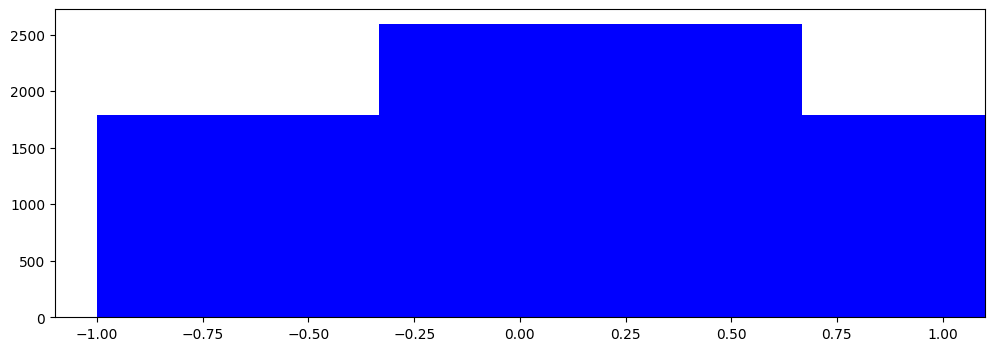

In [179]:
num_of_bins = _cat
hist, bins = np.histogram(y, num_of_bins)
fig, axes = plt.subplots(1, 1, figsize=(12, 4))
axes.hist(y, bins=num_of_bins, width=1, color="blue")

## Training RandomForestClassifier

In [180]:
label_encoder = LabelEncoder()
label_y = label_encoder.fit_transform(y)
print(label_y.shape)

(6170,)


In [184]:
X_train, X_test, y_train, y_test = train_test_split(X, label_y, test_size=0.2, random_state=42)

k_best = SelectKBest(score_func=f_classif, k=30)
k_best.fit(X_train, y_train)
selected_feature_indices = k_best.get_support(indices=True)
print("selected_feature_indices: ", selected_feature_indices)
# angles = selected_feature_indices * 0.6
# print("selected_feature_angles : ", angles)

# selected_feature_indices = []
# for i in range(_roi_start, _roi_end, 1):
#     selected_feature_indices.append(i)
# selected_feature_indices = np.array(selected_feature_indices)
# print("selected_feature_indices: ", selected_feature_indices)
# angles = selected_feature_indices * 0.6
# print("selected_feature_angles : ", angles)

clf = RandomForestClassifier(max_depth=60, random_state=42, n_estimators=100, criterion="gini")
X_train_lim = X_train[:, selected_feature_indices]
clf.fit(X_train_lim, y_train)

X_test_lim = X_test[:, selected_feature_indices]
y_pred = clf.predict(X_test_lim)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

selected_feature_indices:  [ 66  68  70  78  79  80  81  82  83  84  85  87  89 210 212 214 215 216
 217 218 219 220 221 222 228 229 231 232 233 237]
Accuracy: 0.7212317666126418


In [186]:
t = clf.predict(X_test[0:50, selected_feature_indices].reshape(-1, len(selected_feature_indices)))
print(t)
print(np.round(y_test[0:50]))

[1 2 1 2 0 0 0 0 0 1 1 1 1 0 1 1 1 2 0 1 1 2 0 2 1 2 1 1 2 0 0 2 2 1 2 2 0
 1 1 2 1 2 2 1 2 2 0 1 1 0]
[1 2 1 2 1 0 1 0 0 1 1 1 1 1 1 1 1 2 0 1 1 1 0 2 1 2 1 1 2 1 1 2 1 1 1 2 0
 0 2 2 1 2 1 0 2 2 0 1 0 1]


In [189]:
class_names = []
for c in label_encoder.classes_:
    class_names.append(str(c))
print(class_names)

report = classification_report(y_test, y_pred, target_names=class_names, zero_division=0)
print("Classification Report:\n", report)

['-1.0', '-0.0', '1.0']
Classification Report:
               precision    recall  f1-score   support

        -1.0       0.73      0.79      0.76       335
        -0.0       0.71      0.64      0.67       549
         1.0       0.73      0.78      0.75       350

    accuracy                           0.72      1234
   macro avg       0.72      0.74      0.73      1234
weighted avg       0.72      0.72      0.72      1234



## Training with RandomForestRegressor

In [192]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(n_estimators=500, criterion="squared_error", random_state=42, n_jobs=-1)
forest.fit(X_train_lim, y_train)

from sklearn.metrics import mean_squared_error, r2_score

X_test_lim = X_test[:, selected_feature_indices]
y_train_pred = forest.predict(X_train_lim)
y_test_pred = forest.predict(X_test_lim)

print(
    f"train MSE:{mean_squared_error(y_train, y_train_pred)}, test MSE:{mean_squared_error(y_test, y_test_pred)}"
)

print(f"train R2:{r2_score(y_train, y_train_pred)}, test R2:{r2_score(y_test, y_test_pred)}")

t = forest.predict(X_test[0:50, selected_feature_indices].reshape(-1, 30))
print(t)
print(np.round(y_test[0:50]))

train MSE:0.029654052674230144, test MSE:0.22036854132901135
train R2:0.94936883018183, test R2:0.602909221752173
[1.236 1.788 0.88  1.6   0.248 0.234 0.296 0.316 0.284 1.41  0.762 1.336
 1.236 0.248 1.432 1.27  0.972 1.72  0.168 0.872 0.822 1.554 0.168 1.328
 1.258 1.484 1.018 1.582 1.768 0.378 0.288 1.598 1.52  1.416 1.636 1.8
 0.11  0.674 0.886 1.972 1.59  1.698 1.86  0.566 1.36  1.602 0.44  1.046
 1.092 0.448]
[1 2 1 2 1 0 1 0 0 1 1 1 1 1 1 1 1 2 0 1 1 1 0 2 1 2 1 1 2 1 1 2 1 1 1 2 0
 0 2 2 1 2 1 0 2 2 0 1 0 1]


## Training with KNeighborsClassifier

In [146]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=10, p=2, metric="minkowski")
knn.fit(X_train_lim, y_train)

X_test_lim = X_test[:, selected_feature_indices]
y_pred = knn.predict(X_test_lim)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

t = knn.predict(_X[200:300, selected_feature_indices].reshape(-1, 30))
print(t / 2)
print(np.round(_y[200:300] / _div))

Accuracy: 0.6450567260940032
[1.  1.  1.  1.  1.  1.  1.  1.  0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 1.  1.  0.5 0.5 1.  1.  1.  0.5 0.5 0.5 1.  0.5 0.5 0.5 0.5 0.5 0.5 0.
 0.  0.  0.  0.5 0.  0.  0.  0.  0.5 0.5 0.5 0.5 0.5 1.  1.  1.  1.  1.
 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.5 1.  1.  1.  1.  0.5 0.5
 0.5 0.5 0.5 0.5 0.5 1.  0.5 0.5 1.  1.  0.5 0.5 0.5 0.5 0.5 0.5 0.5 1.
 1.  1.  1.  1.  0.5 0.5 1.  1.  1.  1. ]
[ 2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  0.  0. -1. -2. -0.  0.  1.
  2.  2.  0.  0.  2.  2.  2.  2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0. -2. -2. -2. -2. -0.  0.  0.  0.  0.  0.  0.  0.  0.  2.  2.
  2.  0.  1.  2.  2.  2.  2.  2.  2.  1.  1.  1.  2.  2.  2.  2.  2.  0.
  0.  0.  0.  0.  0.  2.  2.  2.  2.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  2.  2.  2.  2.  2.  0.  0.  0.  1.  2.]
